<a href="https://colab.research.google.com/github/lustraka/Predict_Ames_House_Prices/blob/main/collab/Ames-Housing-EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏘️ Ames Housing Dataset EDA
## Import Dependecies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from pandas.api.types import CategoricalDtype # ordered categorical data type, see encode()
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
from scipy import stats # statistical toolset
from scipy.stats import norm # to fit distplot(), though sns.distplot() is a deprecated function

import warnings
warnings.filterwarnings('ignore')

### Set up a data pre-processing module `ames.py`

In [2]:
%%writefile ames.py
"""Download, pre-process Ames Housing dataset."""
# Import dependencies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.api.types import CategoricalDtype # ordered categorical data type, see encode()

def load_data_raw():
    """Load train and test data from Kaggle.com."""

    # Download the Ames Housing Dataset
    # Set the enviroment variables
    import os
    os.environ['KAGGLE_USERNAME'] = "lubomrstraka"
    os.environ['KAGGLE_KEY'] = "c7347462ef834e6645ce238c2f2fa561"

    # Download datasets
    os.system("kaggle competitions download -c house-prices-advanced-regression-techniques --quiet")

    # Read Train & Test Baseline Data
    train_bl = pd.read_csv('train.csv', index_col='Id')
    test_bl = pd.read_csv('test.csv', index_col='Id')

    return train_bl, test_bl

# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The categorical features nominative (unordered)
catn = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig",
        "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", 
        "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", 
        "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", 
        "SaleType", "SaleCondition"]


# The categorical features ordinal (ordered) 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

cato = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
cato = {key: ["None"] + value for key, value in
                  cato.items()}


def encode_dtypes(df):
    """Encode nominal and ordinal categorical variables."""

    global catn, cato

    # Nominal categories
    for name in catn:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in cato.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

def impute_missing(df):
    """Impute zeros to numerical and None to categorical variables."""

    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

def clean_data(df):
    """Remedy typos and mistakes based on EDA."""

    global cato
    # YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
    df.YearRemodAdd = np.where(df.YearRemodAdd < df.YearBuilt, df.YearBuilt, df.YearRemodAdd)
    assert len(df.loc[df.YearRemodAdd < df.YearBuilt]) == 0, 'Check YearRemodAdd - should be greater or equal then YearBuilt'
    
    # Check range of years
    yr_max = 2022
    # Some values of GarageYrBlt are corrupt. Fix them by replacing them with the YearBuilt
    df.GarageYrBlt = np.where(df.GarageYrBlt > yr_max, df.YearBuilt, df.GarageYrBlt)
    assert df.YearBuilt.max() < yr_max and df.YearBuilt.min() > 1800, 'Check YearBuilt min() and max()'
    assert df.YearRemodAdd.max() < yr_max and df.YearRemodAdd.min() > 1900, 'Check YearRemodAdd min() and max()'
    assert df.YrSold.max() < yr_max and df.YrSold.min() > 2000, 'Check YrSold min() and max()'
    assert df.GarageYrBlt.max() < yr_max and df.GarageYrBlt.min() >= 0, 'Check GarageYrBlt min() and max()'
    
    # Check values of ordinal catagorical variables
    for k in cato.keys():
      assert set(df[k].unique()).difference(df[k].cat.categories) == set(), f'Check values of {k}'
    
    # Check typos in nominal categorical variables
    df['Exterior2nd'] = df['Exterior2nd'].replace({'Brk Cmn':'BrkComm', 'CmentBd':'CemntBd', 'Wd Shng':'WdShing'})
    # Renew a data type after replacement
    df['Exterior2nd'] = df['Exterior2nd'].astype("category")
    if "None" not in df['Exterior2nd'].cat.categories:
        df['Exterior2nd'].cat.add_categories("None", inplace=True)

    return df

def label_encode(df):
    """Encode categorical variables using their dtype setting."""

    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

def load_data_clean():
    """Load and data and pre-process them."""

    train_bl, test_bl = load_data_raw()

    train = train_bl.copy()
    train = encode_dtypes(train)
    train = impute_missing(train)
    train = clean_data(train)
    train = label_encode(train)

    test = test_bl.copy()
    test = encode_dtypes(test)
    test = impute_missing(test)
    test = clean_data(test)
    test = label_encode(test)

    return train, test


Overwriting ames.py


## Download the Ames Housing Dataset

In [3]:
import ames
print(help(ames))

Help on module ames:

NAME
    ames - Download, pre-process Ames Housing dataset.

FUNCTIONS
    clean_data(df)
        Remedy typos and mistakes based on EDA.
    
    encode_dtypes(df)
        Encode nominal and ordinal categorical variables.
    
    impute_missing(df)
        Impute zeros to numerical and None to categorical variables.
    
    label_encode(df)
        Encode categorical variables using their dtype setting.
    
    load_data_clean()
        Load and data and pre-process them.
    
    load_data_raw()
        Load train and test data from Kaggle.com.

DATA
    catn = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'L...
    cato = {'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], 'BsmtExpos...
    five_levels = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    ten_levels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

FILE
    /content/ames.py


None


In [4]:
train_bl, test_bl = ames.load_data_raw()
print(f"train_bl.shape = {train_bl.shape}, test_bl.shape = {test_bl.shape}")

train_bl.shape = (1460, 80), test_bl.shape = (1459, 79)


In [5]:
pd.concat([train_bl.tail(), test_bl.head()])

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,953.0,953.0,GasA,Ex,Y,SBrkr,953,694,0,1647,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2.0,460.0,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000.0
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790.0,Rec,163.0,589.0,1542.0,GasA,TA,Y,SBrkr,2073,0,0,2073,1.0,0.0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2.0,500.0,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000.0
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275.0,Unf,0.0,877.0,1152.0,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0.0,0.0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1.0,252.0,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500.0
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49.0,Rec,1029.0,0.0,1078.0,GasA,Gd,Y,FuseA,1078,0,0,1078,1.0,0.0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1.0,240.0,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125.0
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830.0,LwQ,290.0,136.0,1256.0,GasA,Gd,Y,SBrkr,1256,0,0,1256,1.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1.0,276.0,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500.0
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,NaN
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,NaN
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,NaN
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN

## Know your data

The diagram below show key step of Exporatory Data Analysis (EDA) and feature engineering needed to prepare data for machine learning.

![EDA WorkFlow](http://www.plantuml.com/plantuml/png/ZP71Ri8m38RlUGeVjrSe4m9jEt10ceJs0AOn9I9DaErqgxI7NqX9nNhQiVb_-_lzToEAhAdtfdcBNy57jA1dWYCAUHS8B2eAwOjfzdYPFi65WO967d_CAVB5DE-XZJQBEbv9LkKHi4CNJBFhhqa9UYVYGcS6z6bfUVM40OWviXWC5c9IxuWNjWbYMbJg8hiMVJPGjjypV5zzP2hf5JjIU4h13SWEZvv0DDdnUPLzeld1oRauwHO8rSKmdxp-k-j28vm8DJ49O2ZrE0OcNyO4DDwPNA1zyZfXjLBdcYOOcVqE3ctaPH55ptAMwlg5urC8Zf6Jea5_Qq7F_MC91_BKwfmtdxiLeVvM0DPVMTDihQt6HyX_XGgTpofrLKWcVt0SdAM7SgguDfiydNh_2m00)

<!--
Apply "Decode URL" to the diagram's URL at http://www.plantuml.com/plantuml/uml/ to get the source code of the diagram if changes needed.
-->

# Exploratory Data Analysis
## Make Data Inventory

In [6]:
train_bl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [7]:
with open('data_description.txt', 'r') as txt:
  print(txt.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### Pre-process dataset
Function `ames.load_data_clean()` takes care of input data. Steps:
+ encode dtypes 
+ impute missing values
+ clean errors and outliers
+ label-encode categorical variables

In [8]:
train, test = ames.load_data_clean()
print(f"train.shape = {train.shape}, test.shape = {test.shape}")
print(train.info())

train.shape = (1460, 80), test.shape = (1459, 79)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int8   
 1   MSZoning       1460 non-null   int8   
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   int8   
 5   Alley          1460 non-null   int8   
 6   LotShape       1460 non-null   int8   
 7   LandContour    1460 non-null   int8   
 8   Utilities      1460 non-null   int8   
 9   LotConfig      1460 non-null   int8   
 10  LandSlope      1460 non-null   int8   
 11  Neighborhood   1460 non-null   int8   
 12  Condition1     1460 non-null   int8   
 13  Condition2     1460 non-null   int8   
 14  BldgType       1460 non-null   int8   
 15  HouseStyle     1460 non-null   int8   
 16  OverallQual    1460 non-null   int8   
 17  Ov

In [9]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5,3,65.0,8450,1,2,1,3,3,4,3,5,2,2,0,5,8,6,2003,2003,1,1,12,13,1,196.0,4,3,2,4,3,1,6,706,1,0,150,856,1,5,2,5,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,0,1,2003.0,2,2,548,3,3,3,0,61,0,0,0,0,0,0,4,0,2,2008,8,4,208500
2,0,3,80.0,9600,1,2,1,3,3,2,3,24,1,2,0,2,7,9,1976,1976,1,1,8,8,2,0.0,3,3,1,4,3,4,5,978,1,0,284,1262,1,5,2,5,1262,0,0,1262,0,1,2,0,3,1,3,6,8,1,3,1,1976.0,2,2,460,3,3,3,298,0,0,0,0,0,0,0,4,0,5,2007,8,4,181500
3,5,3,68.0,11250,1,2,2,3,3,4,3,5,2,2,0,5,8,6,2001,2002,1,1,12,13,1,162.0,4,3,2,4,3,2,6,486,1,0,434,920,1,5,2,5,920,866,0,1786,1,0,2,1,3,1,4,6,8,1,3,1,2001.0,2,2,608,3,3,3,0,42,0,0,0,0,0,0,4,0,9,2008,8,4,223500
4,6,3,60.0,9550,1,2,2,3,3,0,3,6,2,2,0,5,8,6,1915,1970,1,1,13,15,2,0.0,3,3,0,3,4,1,5,216,1,0,540,756,1,4,2,5,961,756,0,1717,1,0,1,0,3,1,4,7,8,1,4,5,1998.0,1,3,642,3,3,3,0,35,272,0,0,0,0,0,4,0,2,2006,8,0,140000
5,5,3,84.0,14260,1,2,2,3,3,2,3,15,2,2,0,5,9,6,2000,2000,1,1,12,13,1,350.0,4,3,2,4,3,3,6,655,1,0,490,1145,1,5,2,5,1145,1053,0,2198,1,0,2,1,4,1,4,9,8,1,3,1,2000.0,2,3,836,3,3,3,192,84,0,0,0,0,0,0,4,0,12,2008,8,4,250000


## Explore the Target (`SalePrice`)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64 

Skewness (symmetry): 	1.88288
Kurtosis (flatness): 	6.53628


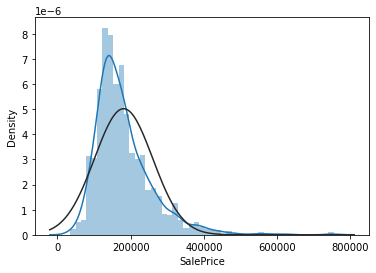

In [10]:
# Overview basic statistical properties
print(train['SalePrice'].describe(), '\n')
# print(df_train['SalePrice'].describe()) # alternatively
# Calculate skewness and kurtosis
print(f"Skewness (symmetry): \t{train['SalePrice'].skew():.5f}")
print(f"Kurtosis (flatness): \t{train['SalePrice'].kurt():.5f}")

# Draw a histogram with a normal distribution fit
sns.distplot(train['SalePrice'], fit=norm)
plt.show()

**Observations**:
+ The variable (`SalePrice`) has no missing values.
+ It deviates from the normal distribution
+ It has appreciable positive skewness (to the right).
+ It shows peakedness.

## Establish the evaluation baseline


In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def score_RMSLE(X, y, model=XGBRegressor()):
    """Use XGBRegressor to calculate RMSLE score."""

    log_y = np.log(y)
    score = cross_val_score(model, X, log_y, cv=5, scoring='neg_mean_squared_error')
    score = -1 * score.mean()
    # Metric is Root Mean Squared Log Error (RMSLE)
    score = np.sqrt(score)

    return score

In [12]:
X = train.copy()
y = X.pop('SalePrice')
score_bl = score_RMSLE(X, y)
print(f"Baseline score : {score_bl:.5f} RMSLE.")

[14:25:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Baseline score : 0.13031 RMSLE.


## Explore the Key Features and Their Relations to the Target
+ Mutual information regression (mi_scores)
+ Correlation
+ Boruta

In [13]:
# Calculate Mutual Information Regression
from sklearn.feature_selection import mutual_info_regression
# All dicreate features should now have integer dtypes
discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name='MIScores', index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores[:10]

OverallQual     0.574372
Neighborhood    0.527004
GarageArea      0.497629
GrLivArea       0.430950
YearBuilt       0.407951
TotalBsmtSF     0.397773
LotArea         0.392750
GarageCars      0.363709
ExterQual       0.334572
BsmtQual        0.326099
Name: MIScores, dtype: float64

In [14]:
# Compute correlation
corr_X_y = X.corrwith(y).abs().sort_values(ascending=False)
corr_X_y = pd.Series(corr_X_y, name='Correlation')
corr_X_y[:10]

GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
BsmtQual        0.585207
FullBath        0.560664
GarageFinish    0.549247
Name: Correlation, dtype: float64

In [15]:
# Select features by Boruta
!pip install boruta
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [16]:
clf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
clf.fit(X, y)

# Define Boruta feature selection method
feat_selector = BorutaPy(clf, n_estimators='auto', verbose=0, random_state=1)

# Find all relevant features
# NOTE BorutaPy accepts numpy arrays only, hence the .values attribute
feat_selector.fit(X.values, y.values)

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=5,
                                          max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=40, n_jobs=-1,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7FF7C32D37C0,
                                          verbose=0, warm_start=F

In [17]:
# Observation: Unforunately no feature recommended by this algorithm
feat_selector.n_features_

0

In [18]:
# Notice: no feature with rank 1
feat_selector.ranking_

array([49, 30, 13,  5, 55, 78, 35, 69, 80, 73, 69, 17, 63, 26, 72, 65, 23,
       23,  7, 16, 58, 74, 38, 35, 33,  8, 41, 31, 40, 53, 65, 43, 58, 10,
       47, 20,  4, 11, 23, 71, 75, 61,  3,  9, 42,  2, 53, 47, 32, 39, 19,
       79, 60, 15, 55, 34, 45, 58, 12, 67, 28,  6, 51, 69, 77, 13, 18, 21,
       64, 27, 49, 45, 75, 37, 23, 29, 44, 62, 52])

In [19]:
# Use features accordning to rank
boruta_rank = pd.Series(feat_selector.ranking_, index=X.columns, name='Boruta')
boruta_rank =  80 - boruta_rank # Convert rank to score
boruta_rank = boruta_rank.sort_values(ascending=False)
boruta_rank[:10]

GrLivArea      78
1stFlrSF       77
BsmtUnfSF      76
LotArea        75
GarageArea     74
YearBuilt      73
MasVnrArea     72
2ndFlrSF       71
BsmtFinSF1     70
TotalBsmtSF    69
Name: Boruta, dtype: int64

In [20]:
# Report top features for next step
top_features = pd.concat([mi_scores[:10], corr_X_y[:10], boruta_rank[:10]], axis=1)
top_features

,MIScores,Correlation,Boruta
OverallQual,0.574372,NaN,NaN
Neighborhood,0.527004,NaN,NaN
GarageArea,0.497629,0.623431,74.0
GrLivArea,0.430950,0.708624,78.0
YearBuilt,0.407951,NaN,73.0
TotalBsmtSF,0.397773,0.613581,69.0
LotArea,0.392750,NaN,75.0
GarageCars,0.363709,0.640409,NaN
ExterQual,0.334572,0.682639,NaN
BsmtQual,0.326099,0.585207,NaN


In [21]:
# Compare feature selection with a baseline score
print(f"Baseline score : {score_bl:.5f} RMSLE.")
print(f"Top-Features score : {score_RMSLE(X.loc[:,top_features.index], y):.5f} RMSLE.")
"""Observation: Using only selected features doesn't improve the score."""

Baseline score : 0.13031 RMSLE.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Top-Features score : 0.14261 RMSLE.


"Observation: Using only selected features doesn't improve the score."

In [24]:
mi_scores[mi_scores==0].index

Index(['PoolQC', 'MoSold', 'YrSold'], dtype='object')

In [25]:
score_RMSLE(X.drop(columns=mi_scores[mi_scores==0].index), y)
"""Dropping uninformative features improve the score"""

[14:41:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:41:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:41:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:41:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:41:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.1299626955997075

In [27]:
mi_scores[-5:]

Utilities    1.887379e-15
PoolArea     2.220446e-16
PoolQC       0.000000e+00
MoSold       0.000000e+00
YrSold       0.000000e+00
Name: MIScores, dtype: float64

In [28]:
score_RMSLE(X.drop(columns=mi_scores[-5:].index), y)

[14:48:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.13019570733045785